In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

# Regression with the Ames Housing Dataset
a modern, more challenging alternative to the well-known Boston Housing dataset

In [65]:
train_df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
train_df.shape, train_df.columns

((1460, 81),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
      

The **Ames Housing dataset** comprises of **80 input variables** and **1 target variable**. For a description of each input variable, please see the data_description.txt included in the dataset.

## The target variable: SalePrice
Let's take a look at our target variable, "SalePrice" which is the house selling price in dollars:

In [66]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

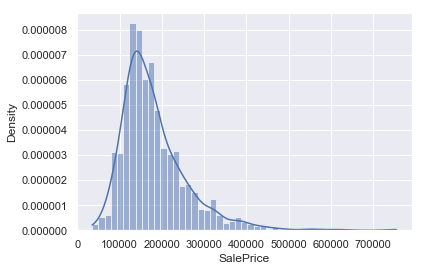

In [86]:
sns.histplot(train_df['SalePrice'], stat='density', kde=True)

The histogram above shows that the distribution looks like a normal distribution but one that it's skewed to the right.

Numerically, the distribution's asymmetry can be described by **Skewness** (positive means skewed to the right) and **Kurtosis** (bigger positive means "heavy-tailed"):

In [68]:
print("Skewness: %f" % (train_df['SalePrice'].skew()))
print("Kurtosis: %f" % (train_df['SalePrice'].kurt()))

Skewness: 1.882876
Kurtosis: 6.536282


# Exploring the input variables
In the next section, let's explore the variables with the eventual goal of feature selection (i.e. deciding which variables to use) and feature engineering (i.e. generating new features) for predicting house pricing.

### Correlation matrix
A quick way to get an overview of the features available is the correlation matrix.
Quick and dirty way of interpreting the correlation matrix:
* high positive correlation => likely **directly proportional**
* high negative correlation => likely **indirectly proportional**
* near 0 correlation between 2 variables means no relation

Let's try plotting the correlation matrix only for the top **k** correlation with target variable **SalePrice**

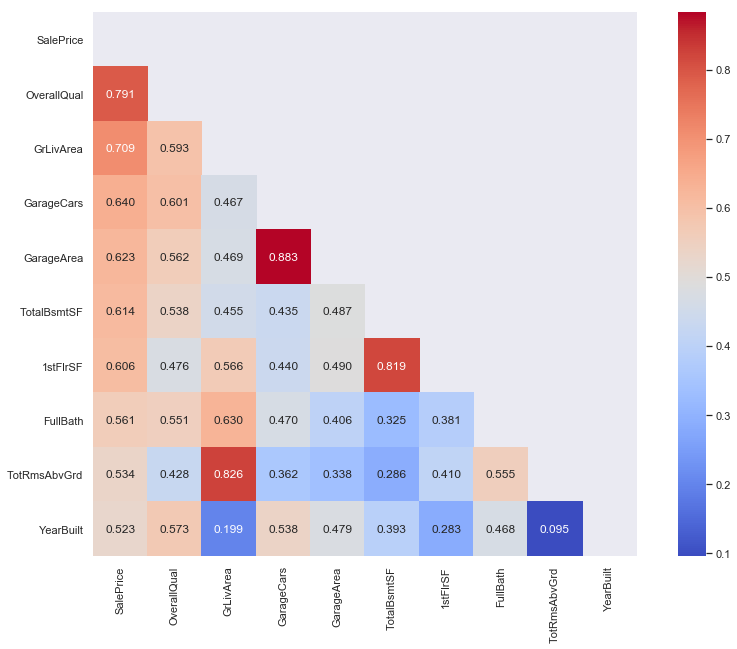

In [77]:
k = 10
corr_matrix = train_df.corr()
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].T)
mask = np.triu(np.ones_like(cm, dtype=bool))

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, yticklabels=cols.values, xticklabels=cols.values,square=True, cmap='coolwarm', mask=mask, fmt='.3f', annot=True)

Observations: redundant input fields (field to retain, i.e. higher corr with SalePrice, in **bold face**):
 * **GarageCars** and GarageArea
 * **TotalBsmtSF** and 1stFlrSF
 * **GrLivArea** and TotRmsAbvGrd
 
The rest of the input fields with significant correlation with 'SalePrice' are:
 * **OvarallQual**: a somewhat obvious predictor for **SalePrice**. It could even be used as an alternative target variable!
 * **FullBath**: wow. who could've thought the number of "full baths" in a house could be a factor for the house price.
 * **YearBuilt**: only slightly correlated, but it's part of the top k.


## Scatter plots for candidate fields
At this point, we have our candidate input variables that have the highest correlation with our target variable. Let's now dive in a little bit more and see how their scatterplots look like:

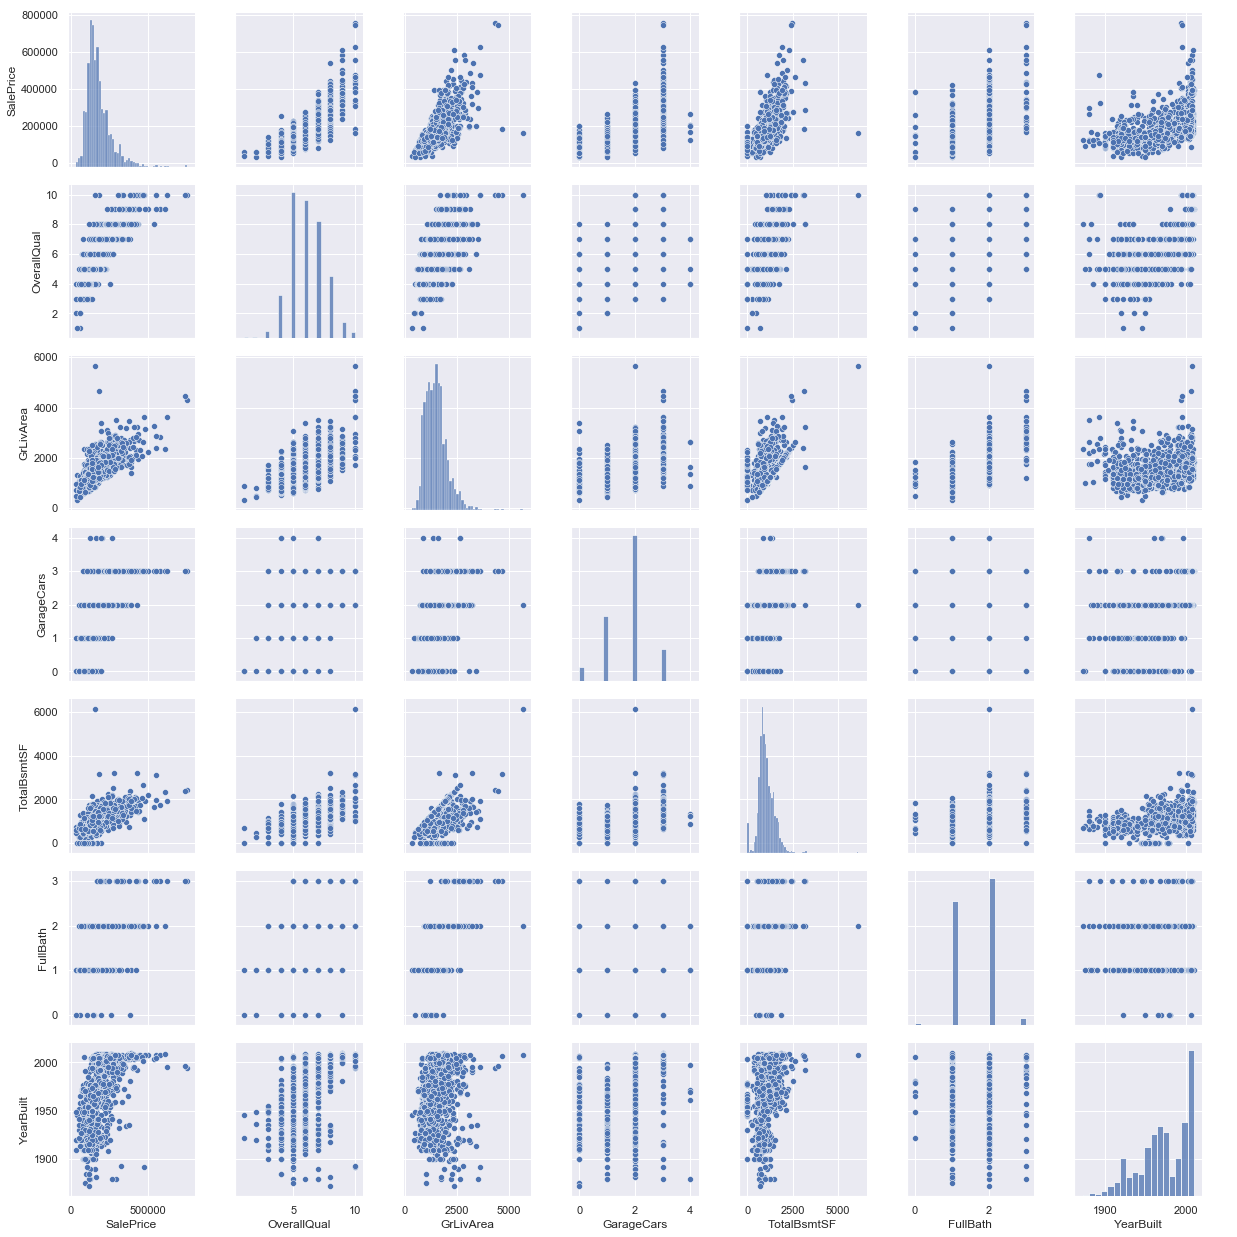

In [70]:
sns.set()
# column names in order of highest to lowest correlation to 'SalePrice'
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], height=2.5)
plt.show();

Scatter plot observations:
* **GrLiveArea** vs. **TotalBsmtSF**  plot shows that the the basement area does not exceed living room area, indicated by an almost-solid border line where most instances fall under. It makes sense that houses have basements equal to or less than the ground living area!
* **YearBuilt** vs. **SalePrice** plot shows an upper-bound that is exponentially increasing trend, implying that houses are becoming more and more expensive as the years go by. Is it because the available liveable land areas are getting scarce compared to the current population?

Let's look more closely at the relationship between **SalePrice** and **OverallQual**:

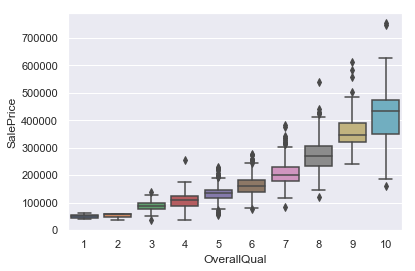

In [71]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)

The power relationship (order=??) between **OverallQual** and **SalePrice** is more obvious in this plot, while noting the increasing spread over **SalePrice** as the quality rating gets higher. Does this indicate that the **OverallQual** is a subjective metric rather than a quantitatively specific one?

Let's look closer as well to the relationship between **YearBuilt** and **SalePrice**:

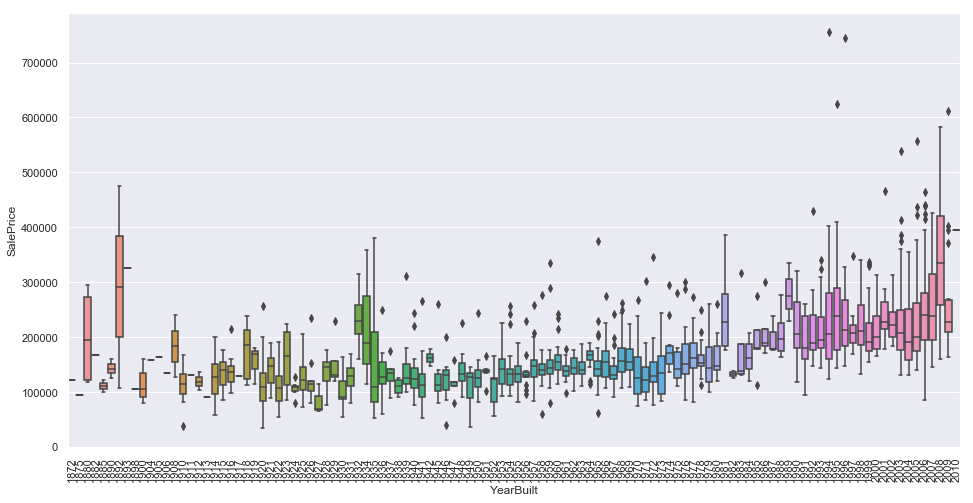

In [72]:
f, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.xticks(rotation=90);

It comes as no surprise that more recently built houses have, in general, higher prices. However we also observe there are relatively old houses that are expensive, perhaps because of their antiquity rather than their quality/structural integrity.

# Missing Data?
We have so far got our hands dirty on the specific input variables, but we haven't so much as checked whether there were missing data (i.e. NULL, None, or NaN entries) in our dataset. Important questions that need to be raised regarding missing data include:
* How much of our data have missing data?
 * *If we simply remove entries with missing data, we might end up with too little data to make an analysis with*
* Is there a pattern to the blanks in our data or is it just random?

Let's check on a per-field basis to check if we can simply drop fields/variables that have a significant amount of missing data. And if all else fails, we may have to delete some instances/observations if there are only a few instances missing from a field.

In [73]:
missing_count = train_df.isnull().sum().sort_values(ascending=False)
percents = ((train_df.isnull().sum()/train_df.isnull().count())).sort_values(ascending=False)
missing_data = pd.concat([missing_count, percents], axis=1, keys=['total_num', '%'])
missing_data.head(20)

,total_num,%
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Comments on missing data:
* The top **k** correlated fields we have identified earlier have no missing data. (Thankfuly!)
* The fields with the highest number of missing data (**PoolQC**, **MiscFeature**, ..., **LotFrontage**) have a relatively low correlation with the target variable. It's safe to assume that they can be dropped.
* **Garage__ fields** in the list of missing data have the same amount of missing data. Suspicious. Anyway, we already have a garage-related input variable (**GarageCars**) which we identified to be highly-correlated with the target variable. Furthermore, we can see the Garage__ fields here are highly correlated with our chosen **GarageCars** field, i.e. it already encompasses the rest of them. Let's decide to drop them.
* Similar comment can be said about the **Bsmt__** fields. Drop!
* Next we have the **MasVnrArea**, **MasVnrType** which are related to the Masonry Veneer. We can see these fields are highly-correlated with **YearBuilt** and **OverallQual** which we assume to encompass the data from these masonry veneer fields. Let's decide to drop these.
* And finally, we have **Electrical** which has one missing instance. Let us decide to delete this instance/observation and keep the rest of the field.

In [74]:
# Drop the fields in missing_data EXCEPT for 'Electrical'
fields_to_drop = missing_data[missing_data['total_num']>1].index
train_df = train_df.drop(labels=fields_to_drop, axis=1)

index_to_drop = train_df.loc[train_df['Electrical'].isnull()].index
train_df = train_df.drop(index_to_drop)

In [75]:
#Check if there are still missing data...
missing_count = train_df.isnull().sum().max()
missing_count

0

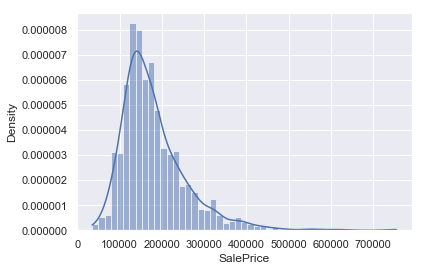

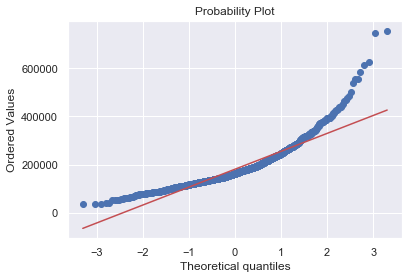

In [87]:
sns.histplot(train_df['SalePrice'], stat='density', kde=True)
fig = plt.figure()
stats.probplot(train_df['SalePrice'], plot=plt);

# References
* [Comprehensive data exploration with Python by pmarcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

*END*

*HERE BEGINS THE "SCRATCH PAPER" CELLS USED FOR VARIOUS TESTING/POKING/API-RECALLING WHICH WERE INSTRUMENTAL FOR COMING UP WITH THE MORE CLEAN/FORMAL CONTENT ABOVE. KEPT HERE FOR REFERENCE.*

#### MSSubClass: type of dwelling
This column looks like a numerical variable at first glance, but it is actually number-coded categories.

In [6]:
train_df['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

... and so we must treat them as categorical data!

In [7]:
train_df['MSSubClass'] = pd.Categorical(train_df.MSSubClass)

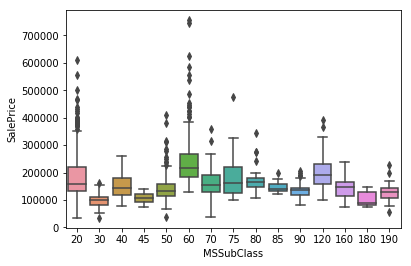

In [8]:
ax = sns.boxplot(x='MSSubClass', y='SalePrice', data=train_df)

Try plotting against SalePrice and LotArea?

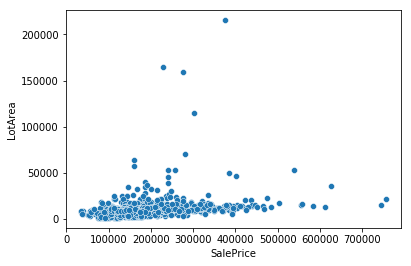

In [10]:
sns.scatterplot(data=train_df, x="SalePrice", y="LotArea")

Correlation matrix: The big BIG picture

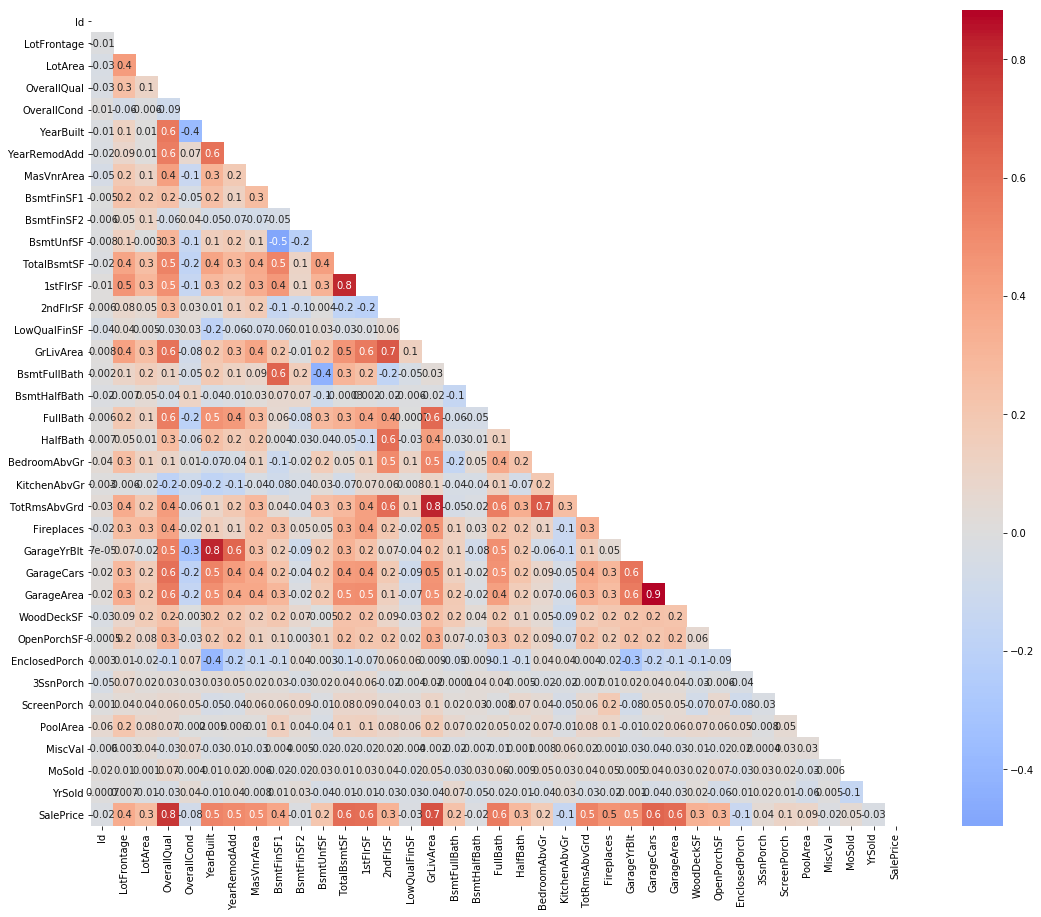

In [12]:
corr_matrix = train_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, square=True, mask=mask, center=0.0, annot=True, fmt='.1g', cmap='coolwarm')

Observations from the correlation heatmap:
* Highly-correlated (likely redundant) fields include:
 * **GarageYrBlt** and **YearBuilt**
 * **TotRmsAbvGrd** and **GrLivArea**
 * **1stFlrSF** and **TotalBsmtSF**
 * **GarageArea** and **GarageCars**
* Input fields that are highly-correlated with our target variable, **SalePrice** include:
 * **OverallQual**
 * **GrLivArea**
 * **TotalBsmtSF** / **1stFlrSF**
 * **FullBath**
 * **GarageCars** / **GarageArea**
 

In [11]:
print(sns.__version__)

0.11.0
